In [ ]:
# download the metadata for all images, 50000 train images, 50000 test images
from huggingface_hub import snapshot_download
snapshot_download(repo_id="osv5m/osv5m", local_dir="datasets/osv5m", allow_patterns=[
    'images/train/00.zip',
    # 'images/train/01.zip',
    'images/test/00.zip',
    # 'images/test/01.zip',
    '*.csv'
    ], repo_type='dataset')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

00.zip:   0%|          | 0.00/2.52G [00:00<?, ?B/s]

00.zip:   0%|          | 0.00/2.25G [00:00<?, ?B/s]

'/content/datasets/osv5m'

In [ ]:
import os
import zipfile
for root, dirs, files in os.walk("datasets/osv5m"):
    for file in files:
        if file.endswith(".zip"):
            with zipfile.ZipFile(os.path.join(root, file), 'r') as zip_ref:
                zip_ref.extractall(root)
                os.remove(os.path.join(root, file))

In [ ]:
import torch
import numpy as np
import pandas as pd
import csv
# Haversine distance - length of an arc between two points on a sphere
# https://github.com/gastruc/osv5m/blob/main/metrics/utils.py
def haversine(pred, gt):
    # expects inputs to be np arrays in (lat, lon) format as radians
    # N x 2

    # calculate the difference in latitude and longitude between the predicted and ground truth points
    lat_diff = pred[:, 0] - gt[:, 0]
    lon_diff = pred[:, 1] - gt[:, 1]

    # calculate the haversine formula components
    lhs = torch.sin(lat_diff / 2) ** 2
    rhs = torch.cos(pred[:, 0]) * torch.cos(gt[:, 0]) * torch.sin(lon_diff / 2) ** 2
    a = lhs + rhs

    # calculate the final distance using the haversine formula
    c = 2 * torch.arctan2(torch.sqrt(a), torch.sqrt(1 - a))
    distance = 6371 * c

    return distance
davis = np.array([[43.547504,-79.662211]])
glasgow = np.array([[55.853467, -4.249420]])

davis_tensor = torch.tensor(davis, dtype=torch.float32).deg2rad()
glasgow_tensor = torch.tensor(glasgow, dtype=torch.float32).deg2rad()

haversine(davis_tensor, glasgow_tensor)

tensor([5307.1450])

In [ ]:
def predict_utm(image_id) -> list[float]:
  # returns the predicted latitude and longitude of a given image
  return [43.547504,-79.662211]

In [ ]:
# https://github.com/gastruc/osv5m/blob/main/metrics/distance_based.py
def geoscore(distance):
  return 5000 * torch.exp(-distance / 1492.7)

In [ ]:
file = open('datasets/osv5m/test.csv', mode='r', newline='', encoding='utf-8')
reader = csv.reader(file)

test_gt = {}
for row in reader:
  if row[0] == 'id':
    continue
  test_gt[int(row[0])] = np.array([float(row[1]), float(row[2])])

file.close()
print(test_gt[1000055667540054])

[60.77272916 -0.83074192]


In [ ]:
# evaluate a predictor by its average geoscore on the first n images from the test set

def evaluate(predictor, n):
  test_path = '/content/datasets/osv5m/images/test/00'
  i = 0
  geoscore_value = 0
  for image_id in os.listdir(test_path):
    id = int(image_id[:image_id.index('.')])
    prediction = np.array(predictor(id))
    gt = test_gt[id]

    prediction_torch = torch.tensor(prediction.reshape(1,2), dtype=torch.float32).deg2rad()
    test_gt_torch = torch.tensor(gt.reshape(1,2), dtype=torch.float32).deg2rad()

    distance = haversine(prediction_torch, test_gt_torch)
    geoscore_value += geoscore(distance)
    i += 1
    if i == n:
      break
  return geoscore_value / n

print("avg geoscore: ",evaluate(predict_utm, 10000).item())

avg geoscore:  310.0566711425781


In [ ]:
from os import listdir
from os.path import isfile, join

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

from tqdm.notebook import trange, tqdm
from time import sleep
import csv
import numpy as np

In [ ]:
!pip install global_land_mask

In [ ]:
# Blocks below contain some code generated with deepseek R1 with the following prompt:
# "write a pytorch model in jupyter format to classify outdoor images by their latitude and longitude"

# Step 2: Define the custom dataset

MAX_FILES = 10000
from global_land_mask import globe
import os.path
from pathlib import Path

class ImageCoordinateDataset(Dataset):
    def __init__(self, csv_file, image_dirs, train: bool, transform=None):
        self.data = []
        self.skipped = []
        self.files = []
        for image_dir in image_dirs:
          self.files.extend([f"{image_dir}/{f}" for f in listdir(image_dir) if isfile(join(image_dir, f))])
        self.csv = 'datasets/osv5m/train.csv' if train else 'datasets/osv5m/test.csv'

        print('Reading', self.csv)
        df = pd.read_csv(self.csv, usecols=range(3))
        row_count, column_count = df.shape
        print('Filtering files...')
        print(self.files[:5])
        print(df[:5])


        # for full_path in tqdm(self.files, total=len(self.files), desc='Processing files'):
        for full_path in tqdm(self.files[:MAX_FILES], total=MAX_FILES, desc='Processing files'):
            image_name = str(Path(full_path).stem)

            row = df[df['id'] == int(image_name)].iloc[0]

            lat = row['latitude']
            lon = row['longitude']

            # Remove mislaballed images (ocean pictures?)
            if not globe.is_land(float(lat), float(lon)):
              self.skipped.append(image_name)
              continue
            self.data.append(np.array([str(full_path), float(lat), float(lon)]))

        self.transform = transform
        print(f'Dataset ready, {len(self.data)} files.')
        print(f'Skipped {len(self.skipped)} non-land files.')


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx][0]
        image = Image.open(img_path).convert('RGB')
        coordinates = (float(self.data[idx][1]), float(self.data[idx][2]))

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(coordinates, dtype=torch.float32)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset = ImageCoordinateDataset(csv_file='datasets/osv5m/train.csv', image_dirs=[
                                      '/content/datasets/osv5m/images/train/00',
                                      # '/content/datasets/osv5m/images/train/01'
                                      ],\
                                 train=True,
                                 transform=transform)
# print(dataset[0])

Reading datasets/osv5m/train.csv
Filtering files...
['/content/datasets/osv5m/images/train/00/860381447890303.jpg', '/content/datasets/osv5m/images/train/00/893850901461526.jpg', '/content/datasets/osv5m/images/train/00/468364617773118.jpg', '/content/datasets/osv5m/images/train/00/862414250978193.jpg', '/content/datasets/osv5m/images/train/00/294384472607126.jpg']
                 id   latitude   longitude
0  3859149887465501 -43.804769 -176.614093
1   574181207305439 -43.796611 -176.660483
2   333574322129026 -43.818092 -176.578383
3   636305258168031 -44.052910 -176.633065
4   166741299029322 -43.748077 -176.329626


Processing files:   0%|          | 0/10000 [00:00<?, ?it/s]

Dataset ready, 9900 files.
Skipped 100 non-land files.


In [ ]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# Step 5: Define the model
if torch.cuda.is_available():
  device = torch.device("cuda")
  print('using cuda')
else:
  device = torch.device("cpu")
  print('using cpu')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class GeoLocationModel(nn.Module):
    def __init__(self):
        super(GeoLocationModel, self).__init__()

        # Convolutional layers to extract features from the image
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Max pooling layer to reduce spatial dimensions
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers to predict latitude and longitude
        self.fc1 = nn.Linear(64 * 28 * 28, 512)  # Adjust input size based on image dimensions
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)  # Output 2 values: latitude and longitude

    def forward(self, x):
        # Apply convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the feature map
        x = x.view(x.size(0), -1)

        # Apply fully connected layers with ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation for the final layer (regression output)

        return x

model = GeoLocationModel().to(device)
# print(model)

using cuda


In [ ]:
# https://github.com/gastruc/osv5m/blob/main/models/losses.py
class HaversineLoss(nn.Module):
    def __init__(self):
        super(HaversineLoss, self).__init__()

    def forward(self, x, y):
        """
        Args:
            x: torch.Tensor Bx2
            y: torch.Tensor Bx2
        Returns:
            torch.Tensor: Haversine loss between x and y: torch.Tensor([B])
        Note:
            Haversine distance doesn't contain the 2 * 6371 constant.
        """
        lhs = torch.sin((x[:, 0] - y[:, 0]) / 2) ** 2
        rhs = (
            torch.cos(x[:, 0])
            * torch.cos(y[:, 0])
            * torch.sin((x[:, 1] - y[:, 1]) / 2) ** 2
        )
        a = lhs + rhs
        return torch.arctan2(torch.sqrt(a), torch.sqrt(1 - a))

In [126]:
# Step 6: Define the loss function and optimizer

from torch.optim.lr_scheduler import ExponentialLR

crossEntropyLoss = nn.CrossEntropyLoss()
haversineLoss = HaversineLoss()
mseLoss = nn.MSELoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [127]:
torch.cuda.empty_cache()

In [128]:
# Step 7: Train the model
num_epochs = 10
avg_epoch_loss = []

w_1 = 0.5
w_2 = 0.25
w_3 = 0.25

for epoch in tqdm(range(num_epochs), total=num_epochs, desc='Epochs'):
  train_loss = []
  avg_loss = 0

  for images, coordinates in tqdm(dataloader, total=len(dataloader), desc=f'Epoch {epoch + 1} progress'):

    # Forward pass
    images, coordinates = images.cuda(), coordinates.cuda()
    outputs = model(images)

    loss_1 = haversineLoss(outputs, coordinates).mean(dim=-1)
    loss_2 = crossEntropyLoss(outputs.softmax(dim=1), coordinates.softmax(dim=1)).mean(dim=-1)
    loss_3 = mseLoss(outputs.softmax(dim=1), coordinates.softmax(dim=1)).mean(dim=-1)

    # print(loss_1.item(), loss_2.item(), loss_3.item())

    total_loss = w_1 * loss_1 + w_2 * loss_2 + w_3 * loss_3

    train_loss.append(total_loss)

    # Backward pass and optimization
    optimizer.zero_grad()
    total_loss.mean(dim=-1).backward()
    optimizer.step()
  scheduler.step()
  avg_loss = sum(train_loss) / len(dataloader)
  avg_epoch_loss.append(avg_loss)
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 progress:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.5681


Epoch 2 progress:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.5678


Epoch 3 progress:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.5665


Epoch 4 progress:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.5667


Epoch 5 progress:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.5658


Epoch 6 progress:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.5640


Epoch 7 progress:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.5626


Epoch 8 progress:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.5604


Epoch 9 progress:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.5607


Epoch 10 progress:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.5586


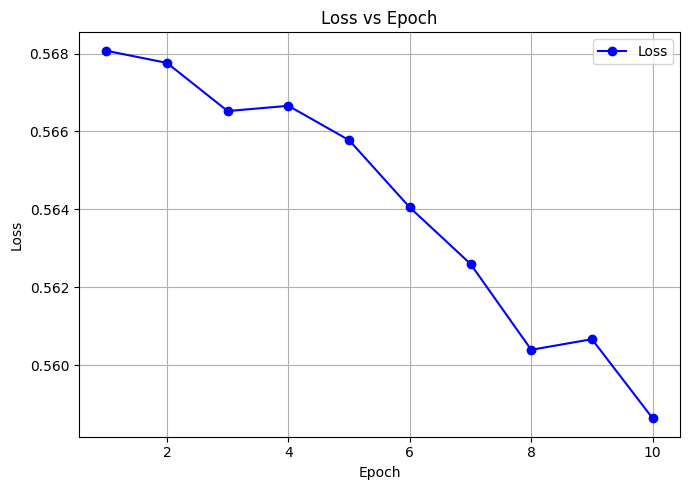

In [129]:

import matplotlib.pyplot as plt
avg_epoch_loss = torch.tensor(avg_epoch_loss, device =  'cpu')
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(avg_epoch_loss) + 1), avg_epoch_loss, label='Loss', color='blue', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [130]:
val_dataset = ImageCoordinateDataset(csv_file='datasets/osv5m/test.csv', \
                                 image_dirs=['/content/datasets/osv5m/images/test/00', \
                                            #  '/content/datasets/osv5m/images/test/01'
                                             ], \
                                     train=False,
                                 transform=transform)
val_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Reading datasets/osv5m/test.csv
Filtering files...
['/content/datasets/osv5m/images/test/00/497572625030815.jpg', '/content/datasets/osv5m/images/test/00/3041046019471728.jpg', '/content/datasets/osv5m/images/test/00/337623801031462.jpg', '/content/datasets/osv5m/images/test/00/5047213021978080.jpg', '/content/datasets/osv5m/images/test/00/516169489406444.jpg']
                 id   latitude  longitude
0   547473234108938 -16.336027  45.628280
1   826109781317024  50.855687  56.147997
2  1006398440000844  37.956651  14.954485
3  2943891539215481  12.373333  -8.909906
4   122945119799579   7.510295  99.061884


Processing files:   0%|          | 0/10000 [00:00<?, ?it/s]

Dataset ready, 9849 files.
Skipped 151 non-land files.


In [131]:
# Model: deepseek r1
# Prompt: now write code to validate this
model.eval()

GeoLocationModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)

In [132]:
# Step 4: Validate the model
val_mse = 0.0
val_haversine = 0.0
val_cel = 0.0

In [133]:
batch_mse = []
batch_haversine = []
batch_cel = []

with torch.no_grad():  # Disable gradient calculation for validation
    for images, coordinates in tqdm(val_dataloader, total=len(dataloader), desc=f'Validating'):
        # Forward pass
        images, coordinates = images.cuda(), coordinates.cuda()
        outputs = model(images)

        loss_1 = haversineLoss(outputs, coordinates).mean(dim=-1)
        loss_2 = crossEntropyLoss(outputs, coordinates.softmax(dim=1)).mean(dim=-1)
        loss_3 = mseLoss(outputs, coordinates.softmax(dim=1)).mean(dim=-1)

        batch_haversine.append(loss_1)
        batch_cel.append(loss_2)
        batch_mse.append(loss_3)

        val_haversine += loss_1
        val_cel += loss_2
        val_mse += loss_3

# Calculate average loss and haversine
val_mse /= len(val_dataloader)
val_cel /= len(val_dataloader)
val_haversine /= len(val_dataloader)

print(f'Validation MSE Loss: {val_mse:.4f}')
print(f'Validation Haversine Loss: {val_haversine:.4f}')
print(f'Validation Cross Entropy Loss: {val_cel:.4f}')

Validating:   0%|          | 0/310 [00:00<?, ?it/s]

Validation MSE Loss: 0.8898
Validation Haversine Loss: 0.7723
Validation Cross Entropy Loss: 0.5199


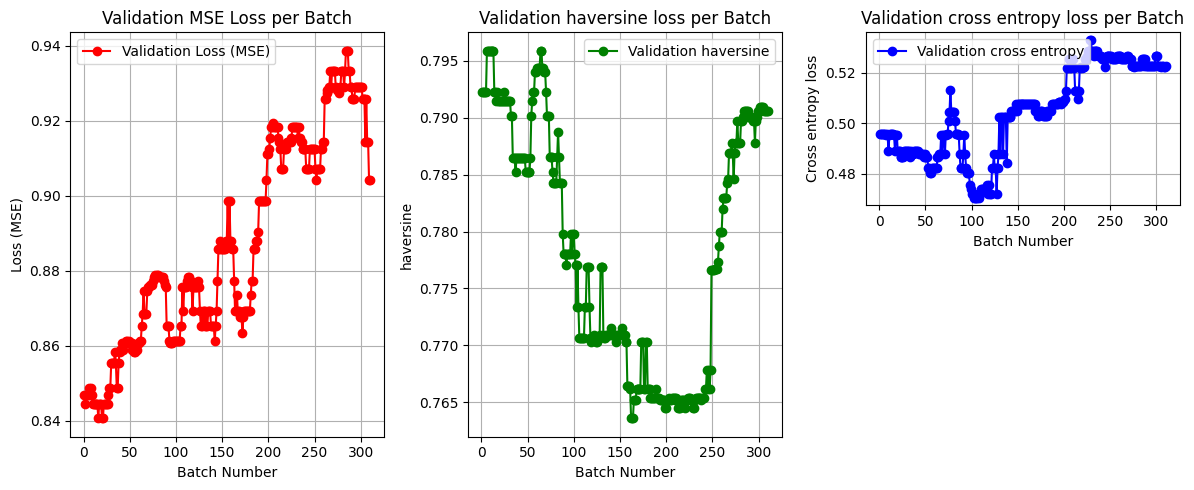

In [134]:
# Model: deepseek r1
# Prompt: write matplotlib code to plot previous validation loop:

import matplotlib.pyplot as plt

# Remove outliers
from scipy.ndimage import median_filter

batch_haversine = torch.tensor(batch_haversine, device =  'cpu')
batch_cel = torch.tensor(batch_cel, device =  'cpu')
batch_mse = torch.tensor(batch_mse, device =  'cpu')

batch_haversine = median_filter(batch_haversine, size=100)
batch_cel = median_filter(batch_cel, size=100)
batch_mse = median_filter(batch_mse, size=100)

# Step 1: Plot Validation Loss per Batch
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, len(batch_mse) + 1), batch_mse, label='Validation Loss (MSE)', color='red', marker='o')
plt.xlabel('Batch Number')
plt.ylabel('Loss (MSE)')
plt.title('Validation MSE Loss per Batch')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(range(1, len(batch_haversine) + 1), batch_haversine, label='Validation haversine', color='green', marker='o')
plt.xlabel('Batch Number')
plt.ylabel('haversine')
plt.title('Validation haversine loss per Batch')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(range(1, len(batch_cel) + 1), batch_cel, label='Validation cross entropy', color='blue', marker='o')
plt.xlabel('Batch Number')
plt.ylabel('Cross entropy loss')
plt.title('Validation cross entropy loss per Batch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [135]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [136]:
# Step 5: Visualize some predictions (optional)
import matplotlib.pyplot as plt
import random

url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

def plot_predictions(model, dataloader, num_samples=5):
    model.eval()
    with torch.no_grad():
        for images, coordinates in dataloader:
            images = images.cuda()
            outputs = model(images)
            images = images.cpu()
            outputs = outputs.cpu()
            rand_index = random.sample(range(0, len(images) - 1), min(num_samples, len(images)))
            for i in range(min(num_samples, len(images))):
                i = rand_index[i]

                pred_lat, pred_lon = outputs[i].cpu().numpy()
                true_lat, true_lon = coordinates[i].numpy()

                haver_err = haversine(
                                      torch.tensor(np.array([[pred_lon, pred_lat]]), dtype=torch.float32).deg2rad(),
                                      torch.tensor(np.array([[true_lon, true_lat]]), dtype=torch.float32).deg2rad(),
                                      )
                # Display the image
                img = images[i].permute(1, 2, 0).numpy()
                img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # Reverse normalization
                img = np.clip(img, 0, 1)

                plt.imshow(img)
                plt.title(f'Pred: ({pred_lat:.4f}, {pred_lon:.4f})\nTrue: ({true_lat:.4f}, {true_lon:.4f})\n Haversine: {haver_err}')
                plt.axis('off')

                # World map for better understanding of how bad our prediction is
                geometry = [Point(pred_lon, pred_lat), Point(true_lon, true_lat)]
                geo_df = GeoDataFrame(geometry = geometry)
                world = gpd.read_file(url)
                geo_df.plot(ax=world.plot(color="lightgrey", figsize=(10, 6)), marker='x', c=['red', 'green'], markersize=50);

                plt.show()
            break

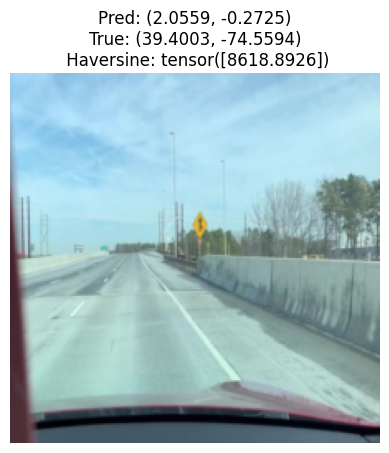

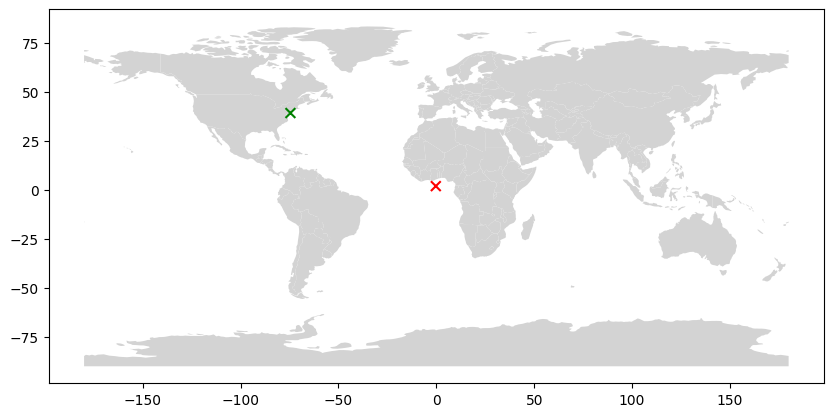

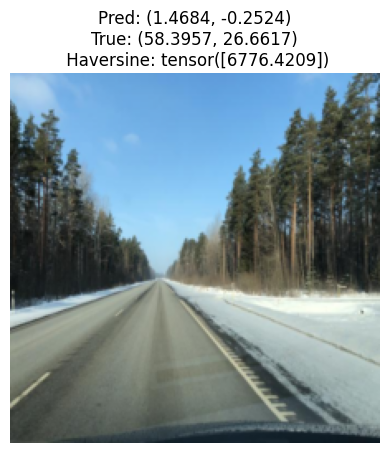

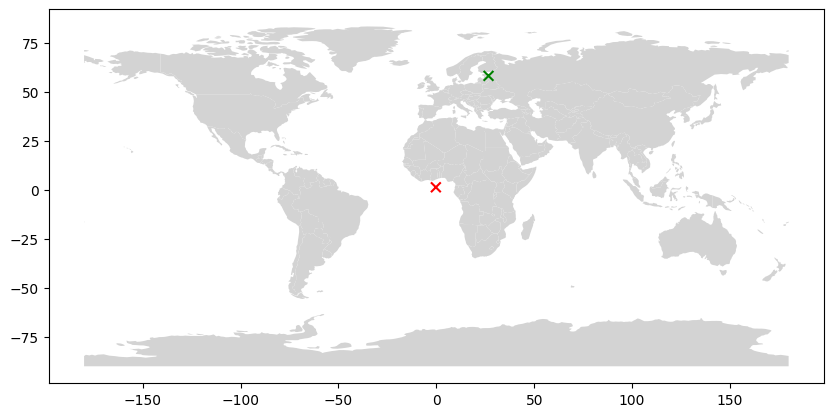

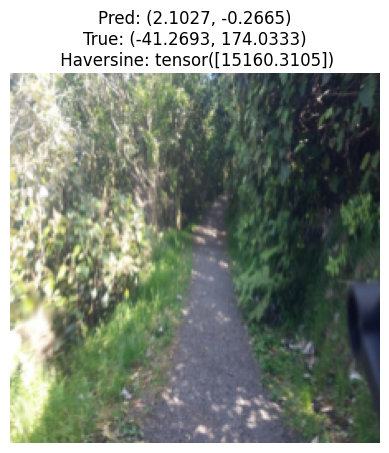

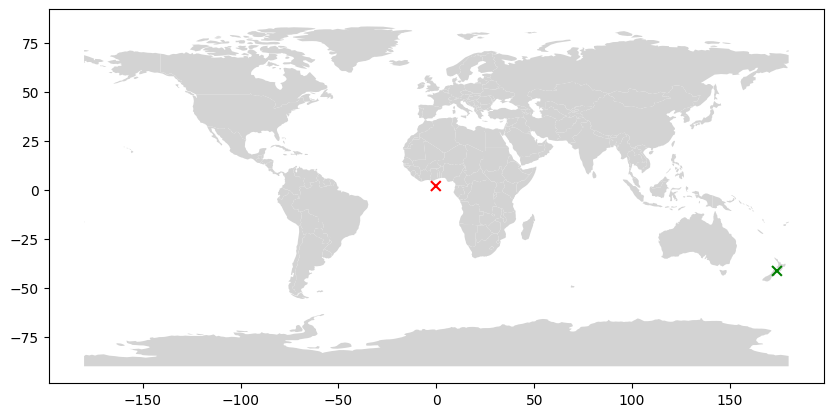

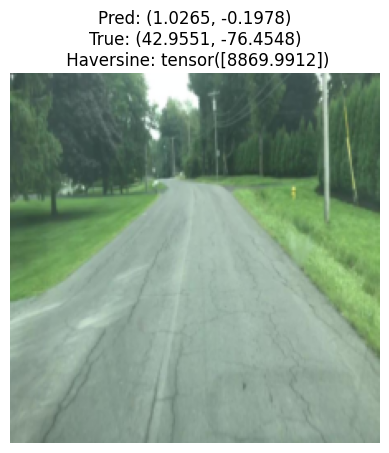

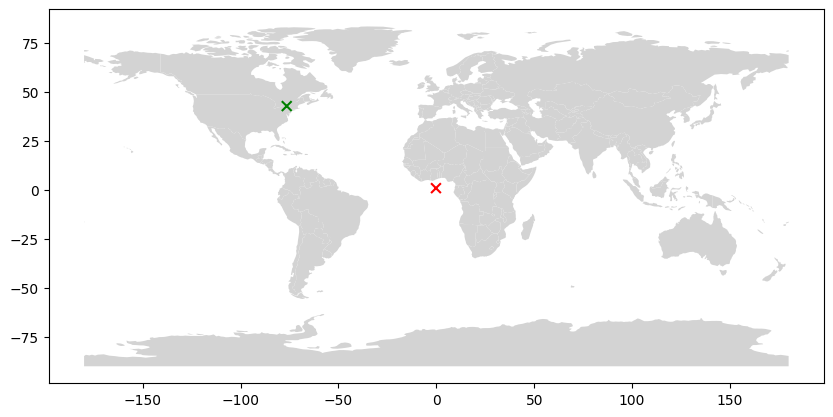

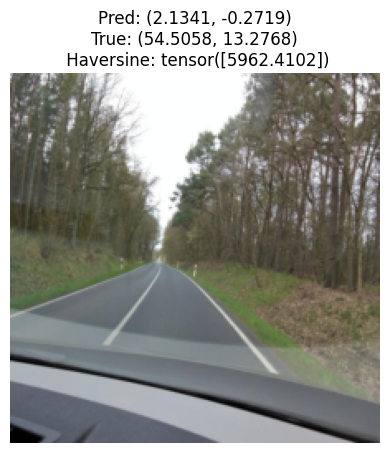

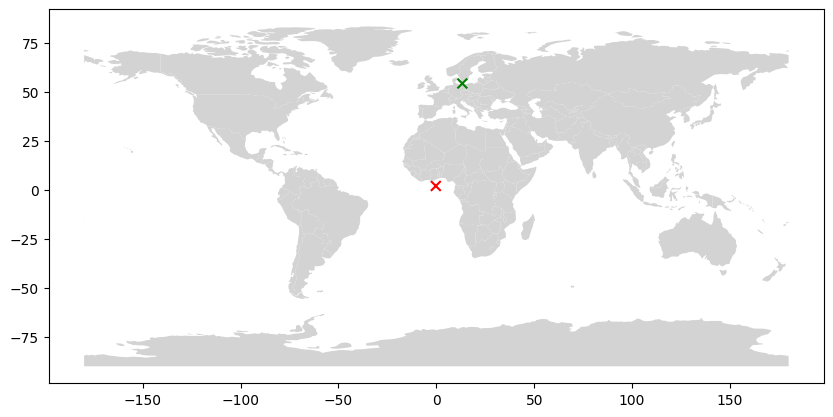

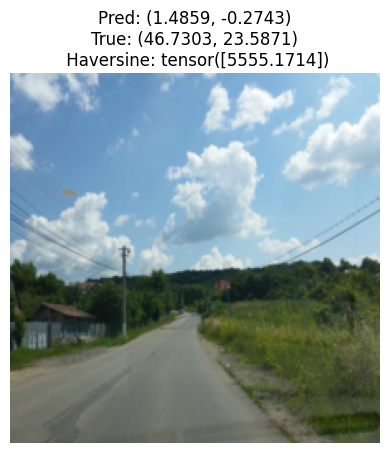

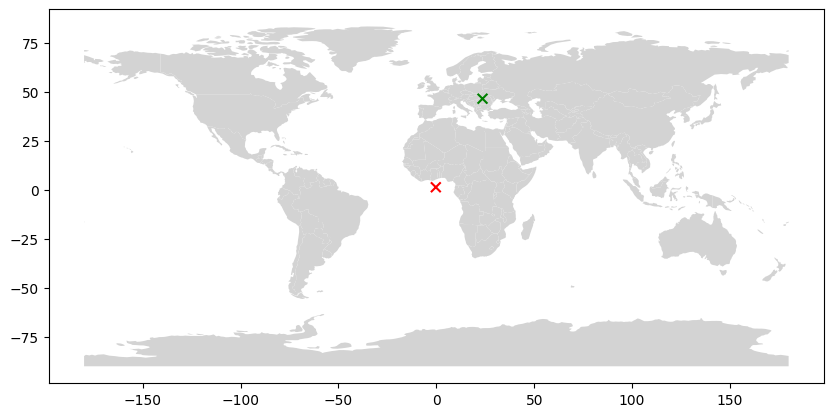

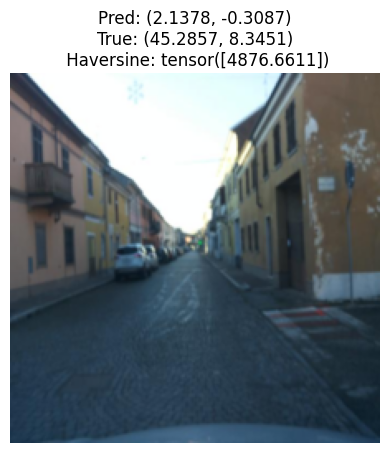

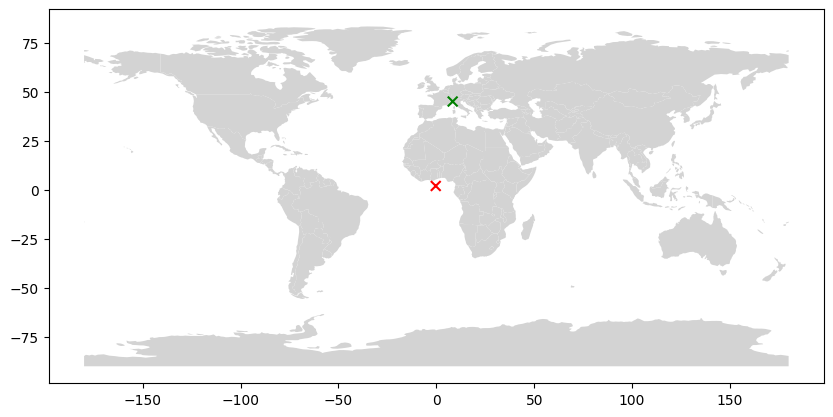

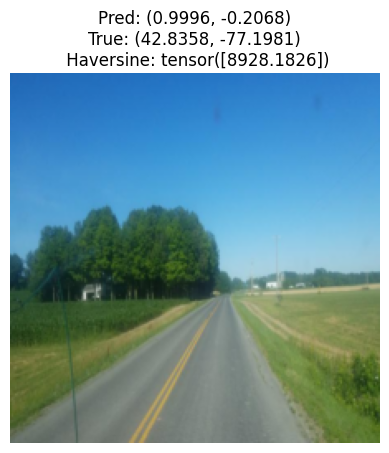

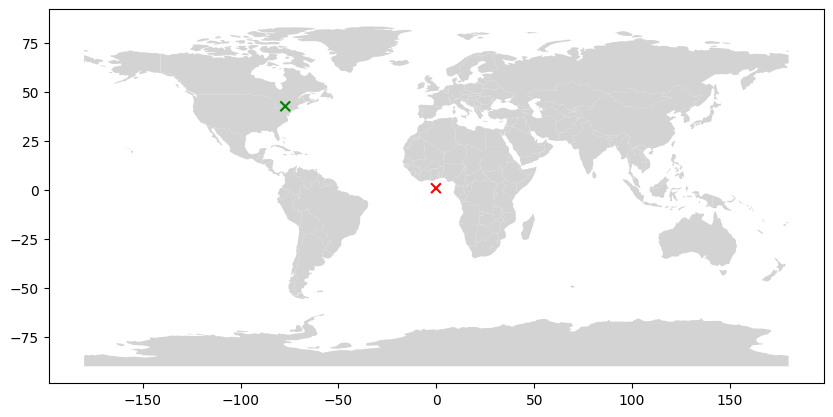

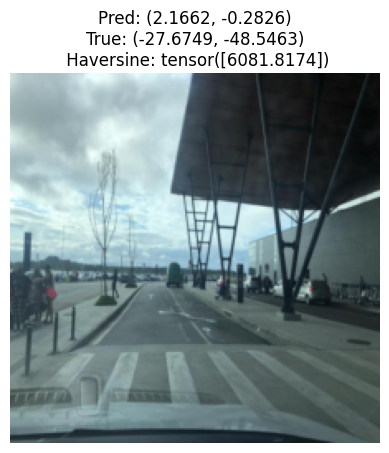

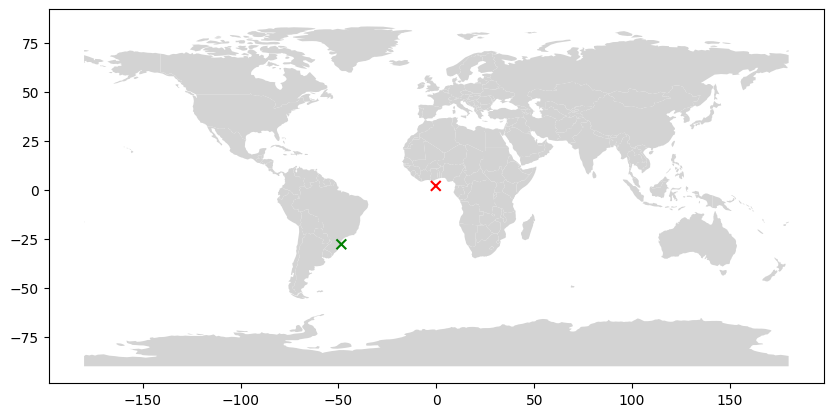

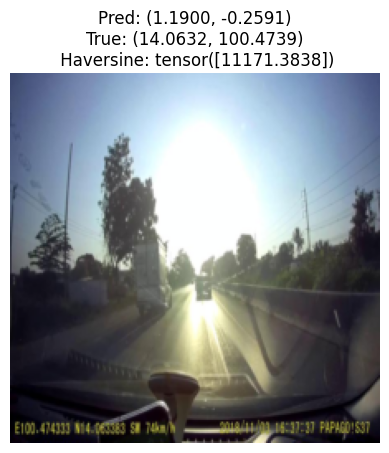

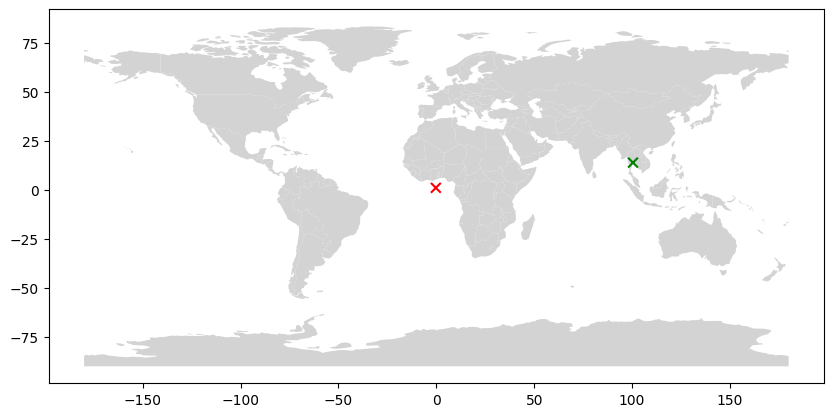

In [137]:
# Plot some predictions
plot_predictions(model, val_dataloader, num_samples=10)